# This script is used for plotting all M vs H runs for a specific compound. You can then choose a run and fit a straight line to extract the saturation magnetization.

In [10]:
import seaborn as sns
sns.set()
import sys
sys.path.append('..')
from JensenTools import *

# Important variable declaration

In [11]:
#####################################################################################################################################################################
who = 'Arun'
comp = 'Sr2PrO4'
MHDir = getSaveDir('m', comp = comp, dataType = 'MH')
molweight = molweight[comp]
#####################################################################################################################################################################

# Load the M vs H data files. Then order them by temperature for prettier plotting. Get the mass and temp from the filename.

In [12]:
# Get all runs from data directory
# Sort the runs by temperature (this makes for prettier plotting).
#####################################################################################################################################################################
runs = [] #A list of all the data file names
for i in os.listdir(MHDir):
    if i.endswith('.DAT') or i.endswith('.dat.'): #This was a safeguard against a situation arising at an earlier implementation of my code.
        runs.append(i)

temp = [] # temporary list for sorting
for i in runs:
    temp.append(getTemp(i, who = who)) # this creates a list of just temperatures as read by the filename   
temp = np.argsort([int(i) for i in temp]) # Sort by temperature
runs = [runs[i] for i in temp] # newly sorted listed
#####################################################################################################################################################################
## Get mass and temp from one of the filenames. Doesn't matter since they should all have the same name/mass.
mass = getMass(runs[0], who = who)
T = getTemp(runs[0], who = who)

## Plot all of the M vs H runs in (emu/spin vs Oe) and (uB/spin vs T)

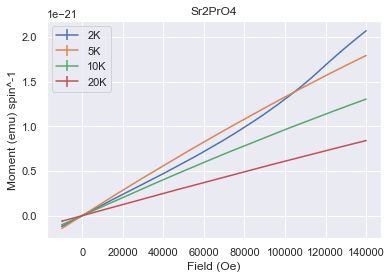

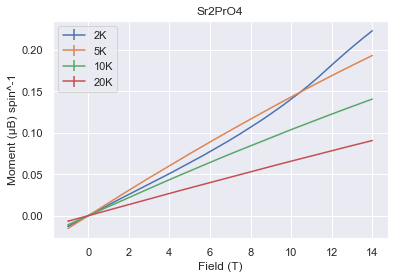

In [13]:
# Normalize measurement to spin^-1
# Plot the data in both Emu/Oe and uB/T
#####################################################################################################################################################################
MHdata = {} #Data will be normalized and stored in Emu/Oe. Conversions to uB/T are done as needed.

# Normalizes and stores data as well as plotting in Emu/Oe for all temperatures.
plt.figure()
for i in runs: 
    M, H, Err, mass, T = getData(i,MHDir,who = who, dataType = 'MH')
    M = normalize(M,mass,molweight,'spin')
    Err = normalize(Err,mass,molweight,'spin')
    MHdata[T] = [M,H,Err,mass,i]
    plt.errorbar(H, M, yerr = Err, label = T)
plt.title(comp)
plt.ylabel('Moment (emu) spin^-1')
plt.xlabel('Field (Oe)')
plt.legend()


#Plot in uB/T for all temperatures
plt.figure()
for i in MHdata.keys():
    M,H,Err,Mass,T = MHdata[i]
    M = emuToBohr2(M)
    H = oeToTesla(H)
    Err = emuToBohr2(Err)
    plt.errorbar(H,M, yerr = Err,label = i)
plt.title(comp)
plt.ylabel('Moment (\N{GREEK SMALL LETTER MU}B) spin^-1')
plt.xlabel('Field (T)')
plt.legend()
plt.show()
#####################################################################################################################################################################


## Select a temperature run to fit to and specifiy over what H field range.

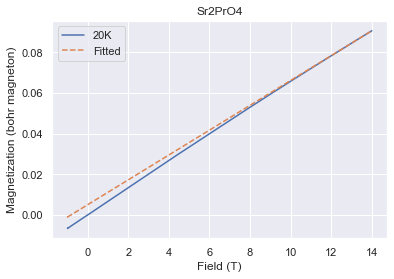

Saturation magnetization =  0.005 uB


In [14]:
# Choose a run to find the saturation magnetization
# Perform a linear fit over a chosen field range (Tesla)
#####################################################################################################################################################################
temp = '20K' #Select a temperature to analyze
curRun = MHdata[temp] #loading the data from my current run

# Converto to uB/T
M = emuToBohr2(curRun[0])
H = oeToTesla(curRun[1])
Err = emuToBohr2(curRun[2])

# Choose the field range to fit over (Tesla)
fieldRange = [13.5,14]
newH = []
newM = []
newErr = []
for i in range(len(M)):
    if (H[i] >= fieldRange[0] and H[i] <= fieldRange[1]):
        newH.append(H[i])
        newM.append(M[i])
        newErr.append(Err[i])

# Create LMFIT Linear Model
linModel = LinearModel()
params = linModel.guess(newM, x = newH)
fitted = linModel.fit(newM, x = newH, weights = newErr)

#Drawing a full line from the fitted results
MLine = []
for i in H:
    MLine.append(fitted.params['slope'].value*i + fitted.params['intercept'].value)

# Plot the data and the fit
plt.plot(H,M, label = temp)
plt.plot(H,MLine, linestyle = '--', label = 'Fitted')
plt.xlabel('Field (T)')
plt.ylabel('Magnetization (bohr magneton)')
plt.legend()
plt.title(comp)
plt.show()

print('Saturation magnetization =  {:.3f} uB'.format(fitted.params['intercept'].value))
#####################################################################################################################################################################